In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('gold_monthly_csv.csv')
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [ ]:
df.shape

(847, 2)

**EDA**

In [ ]:
print(f"Date range of gold prices available from-{df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from-1950-01 to 2020-07


In [ ]:
date = pd.date_range(start='1/1/1950',end='8/1/2020',freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [ ]:
df['month']=date
df.drop('Date',axis=1,inplace=True)
df=df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


AttributeError: module 'matplotlib.pyplot' has no attribute 'ylable'

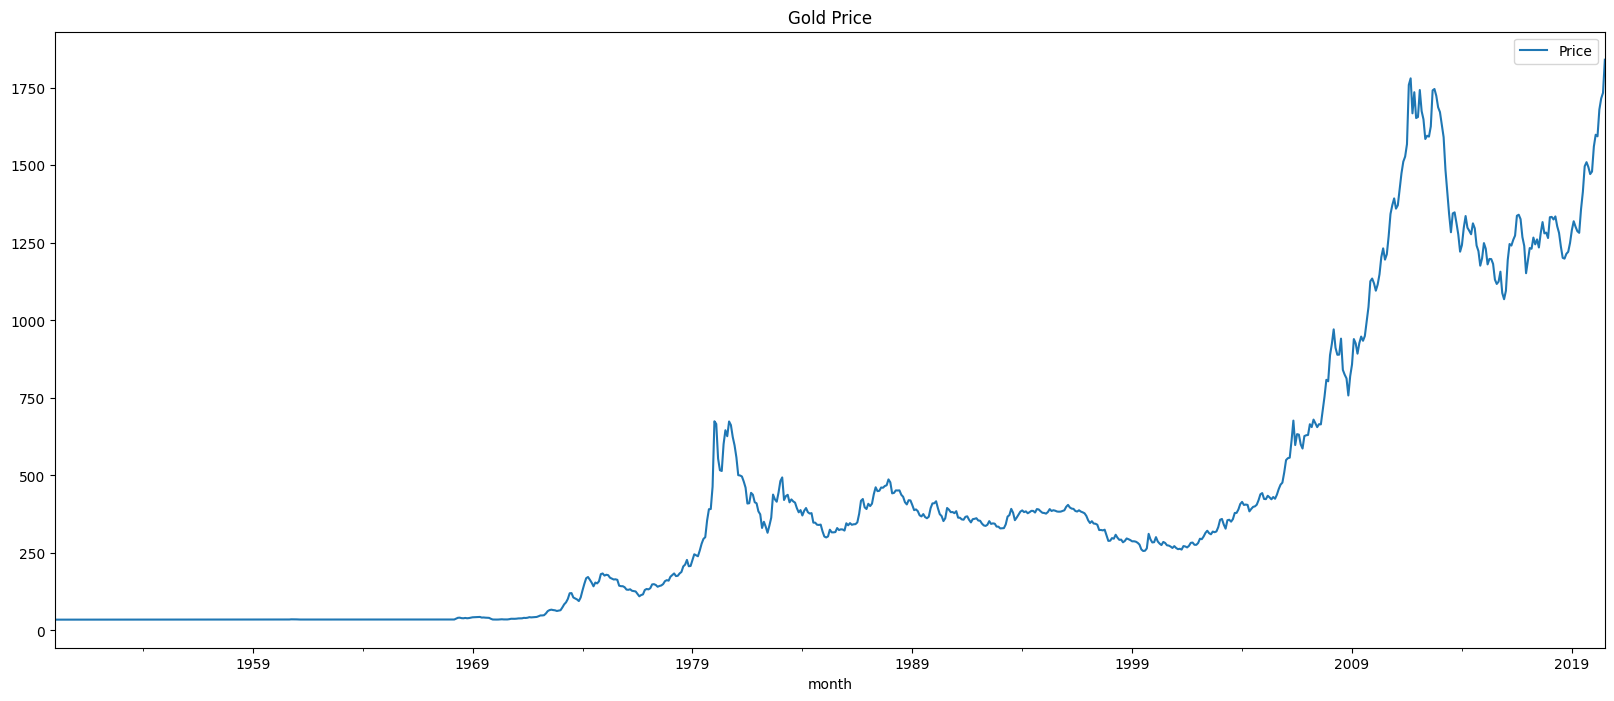

In [ ]:
df.plot(figsize=(20,8))
plt.title('Gold Price')
#plt.xlable('Month')
plt.ylable('Price')
plt.grid()
plt.show()

In [ ]:
round(df.describe(),3)

In [ ]:
_,ax=plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year,y=df.values[:,0],ax=ax)
plt.title('Gold Price Boxplot')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import month_plot
fig, ax=plt.subplots(figsize=(22,8))
month_plot(df,ylabel='Gold Price',ax=ax)
plt.title('Gold Price Monthly Plot')
plt.xlabel('Month')
plt.ylabel('Price')

plt.grid()
plt.show()

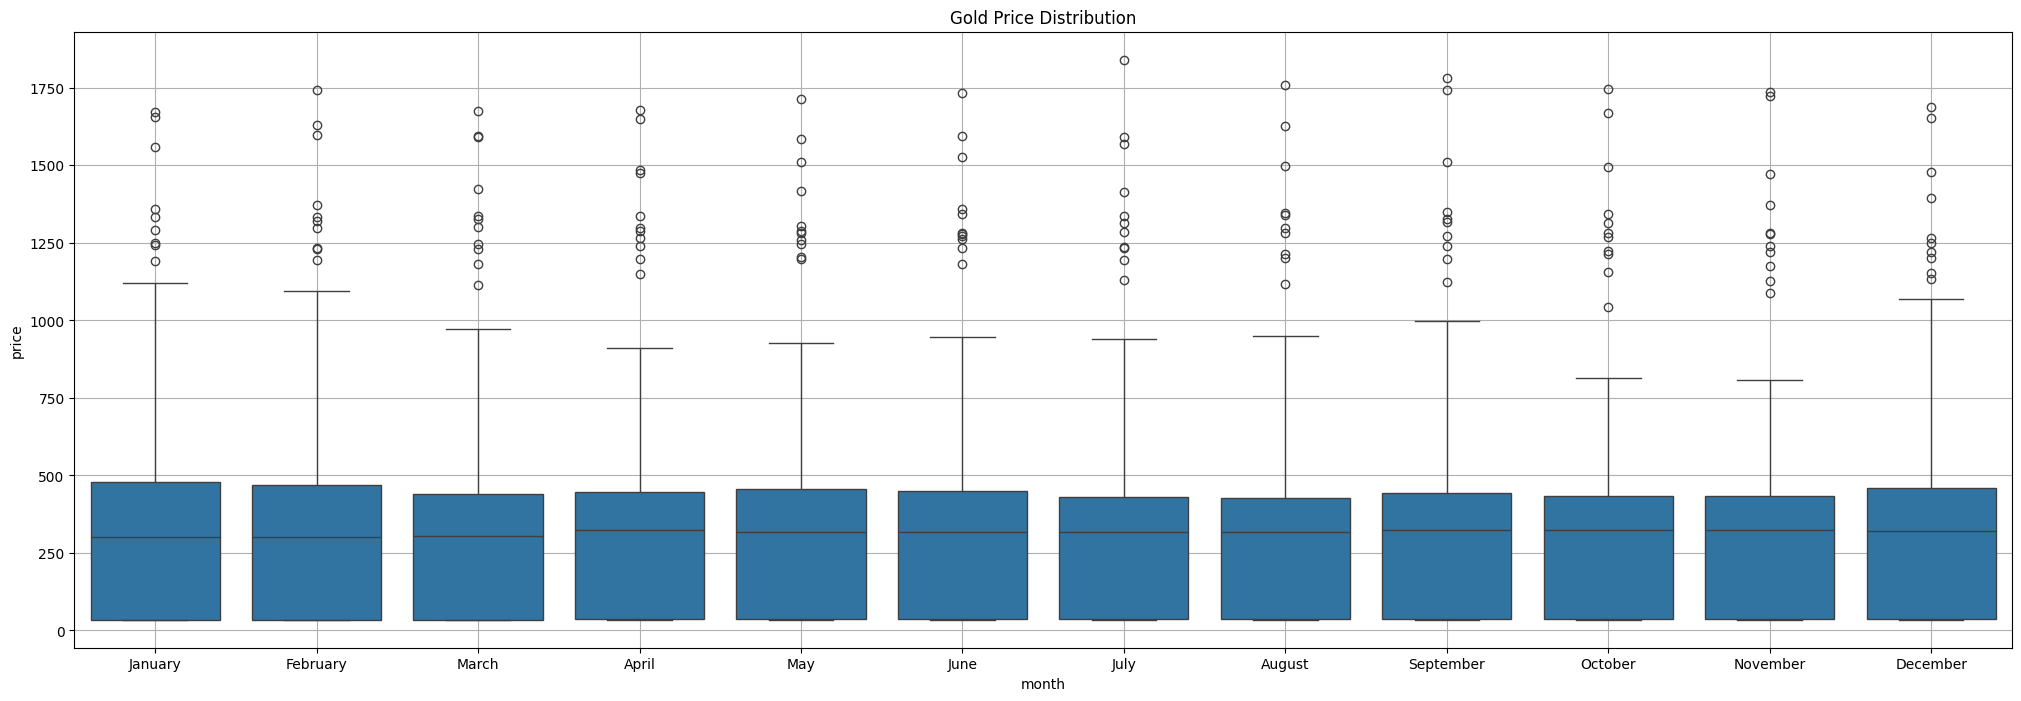

In [ ]:
_, ax=plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.month_name(),y=df.values[:,0],ax=ax)
plt.title('Gold Price Distribution')
plt.xlabel('month')
plt.ylabel('price')
plt.grid()
plt.show()

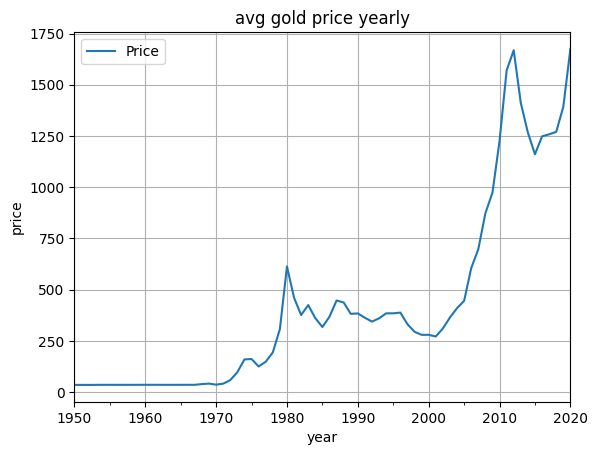

In [ ]:
df_yearly_sum=df.resample('A').mean()
df_yearly_sum.plot()
plt.title('avg gold price yearly')
plt.xlabel('year')
plt.ylabel('price')
plt.grid()
plt.show()

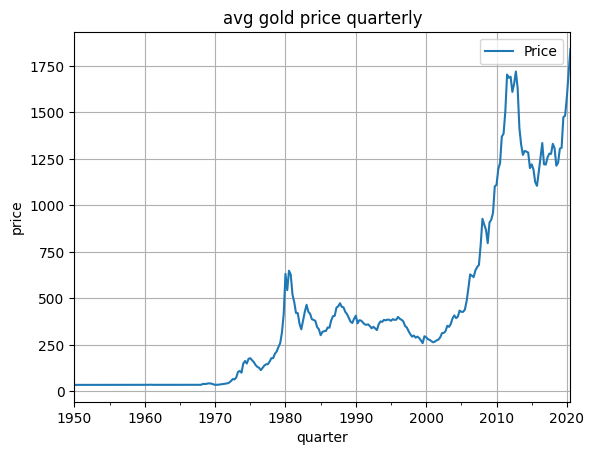

In [ ]:
df_qauterly_sum=df.resample('Q').mean()
df_qauterly_sum.plot()
plt.title('avg gold price quarterly')
plt.xlabel('quarter')
plt.ylabel('price')
plt.grid()
plt.show()

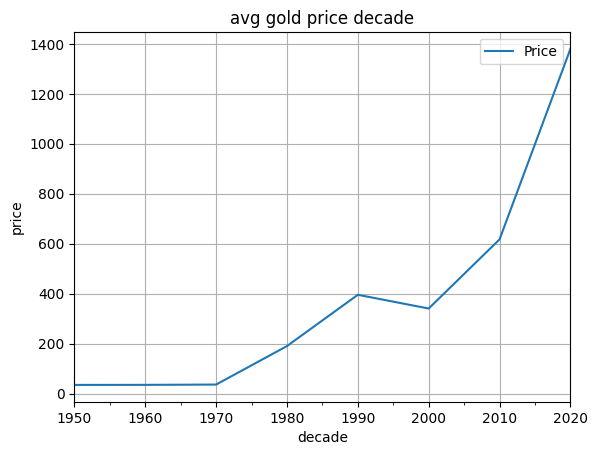

In [ ]:
df_decade_sum=df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('avg gold price decade')
plt.xlabel('decade')
plt.ylabel('price')
plt.grid()
plt.show()

In [ ]:
df_1=df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1=df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['Cov_pct']=((df_1['Std']/df_1["Mean"])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


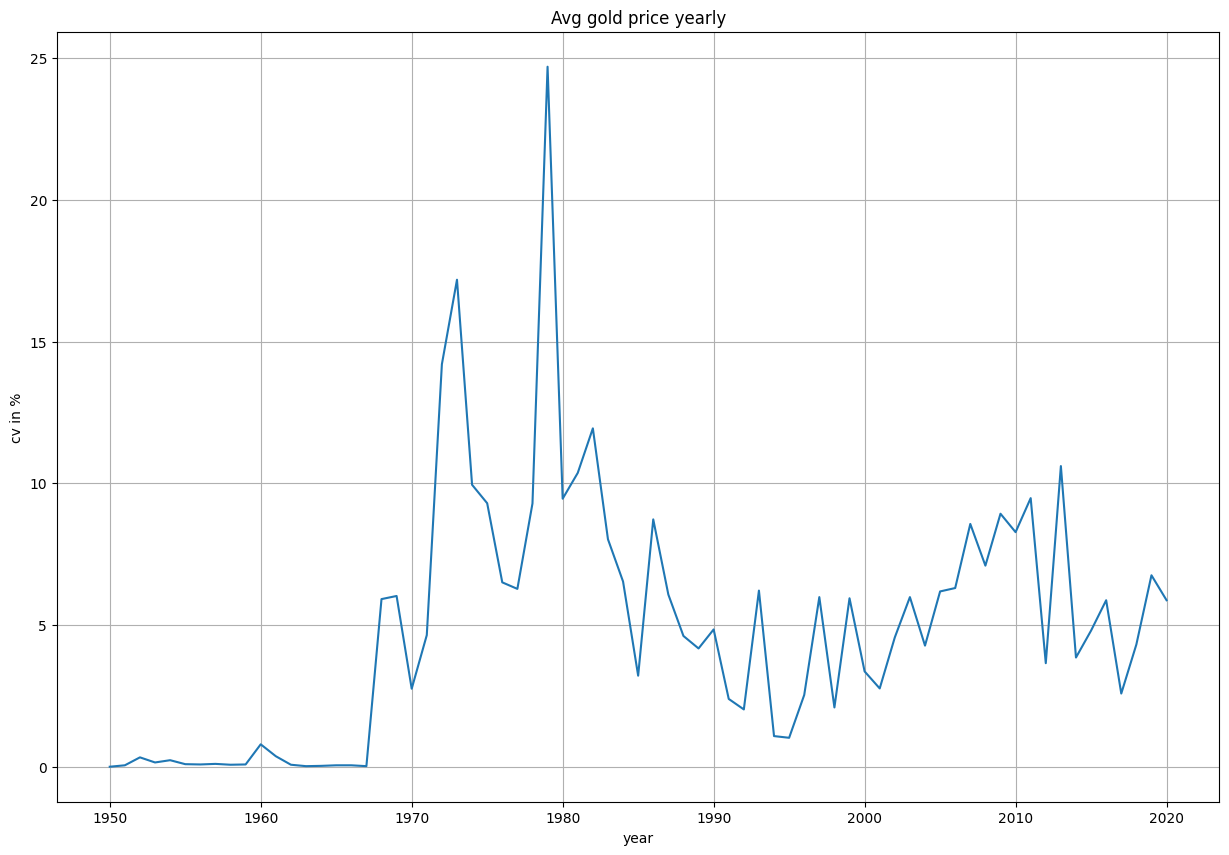

In [ ]:
fig, ax=plt.subplots(figsize=(15,10))
df_1['Cov_pct'].plot()
plt.title("Avg gold price yearly")
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()
plt.show()

In [ ]:
train=df[df.index.year<=2015]
test=df[df.index.year>2015]

In [ ]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


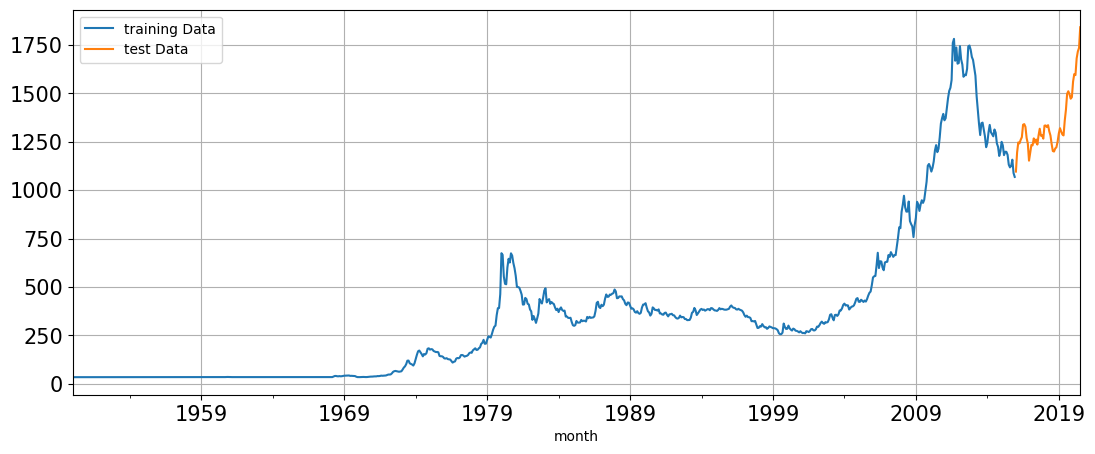

In [ ]:
train["Price"].plot(figsize=(13,5),fontsize=15)
test["Price"].plot(figsize=(13,5),fontsize=15)
plt.grid()
plt.legend(['training Data','test Data'])
plt.show()

**Model Training**

In [ ]:
train_time=[i+1 for i in range(len(train))]
test_time=[i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(792, 55)

In [ ]:
LR_train=train.copy()
LR_test=test.copy()


In [ ]:
LR_train['time']=train_time
LR_test['time']=test_time

In [ ]:
lr=LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

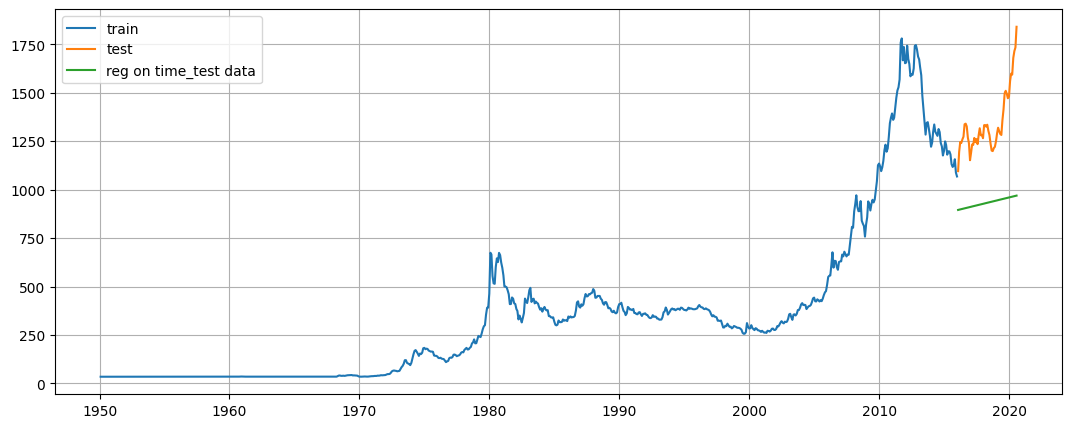

In [ ]:
test_predictions_model=lr.predict(LR_test[['time']])
LR_test['forecast']=test_predictions_model

plt.figure(figsize=(13,5))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')

plt.plot(LR_test['forecast'],label='reg on time_test data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
def mape(actual,pred):
  return round((np.mean(abs(actual-pred)/actual))*100,2)

In [ ]:
mape_model_test=mape(test['Price'].values,test_predictions_model)
print(f"MAPE on test data is {mape_model_test}%")

MAPE on test data is 29.76%


In [ ]:
results=pd.DataFrame({'Test Mape (%)':[mape_model_test]},index=["RegressionOnTime"])
results

,Test Mape (%)
RegressionOnTime,29.76


In [ ]:
Naive_train=train.copy()
Naive_test=test.copy()

In [ ]:
Naive_test['naive']=np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

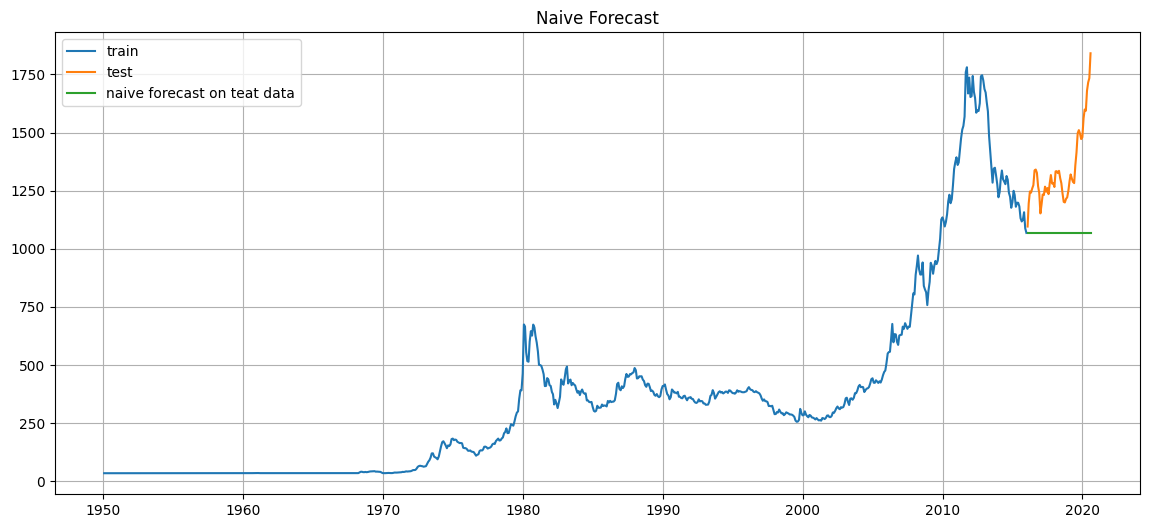

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(Naive_test['naive'],label='naive forecast on teat data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()
plt.show()

In [ ]:
mape_model1_test=mape(test['Price'].values,Naive_test['naive'].values)
print(f"MAPE on test data is {mape_model1_test}%")

MAPE on test data is 19.38%


In [ ]:
results1=pd.DataFrame({'Test Mape (%)':[mape_model1_test]},index=["NaiveModel"])
results=pd.concat([results,results1])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38


In [ ]:
final_model= ExponentialSmoothing(df,trend= 'additive',seasonal='additive').fit(smoothing_level=0.4,smoothing_trend=0.3,smoothing_seasonal=0.6)

In [ ]:
Mape_final_model=mape(df['Price'].values,final_model.fittedvalues)
print('MAPE : ',Mape_final_model)

MAPE :  17.24


In [ ]:
predictions=final_model.forecast(steps=len(test))

In [ ]:
pred_df=pd.DataFrame({'lower_CI':predictions-1.96*np.std(final_model.resid,ddof=1),'predictions':predictions,
                      'upper_CI':predictions+1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,predictions,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


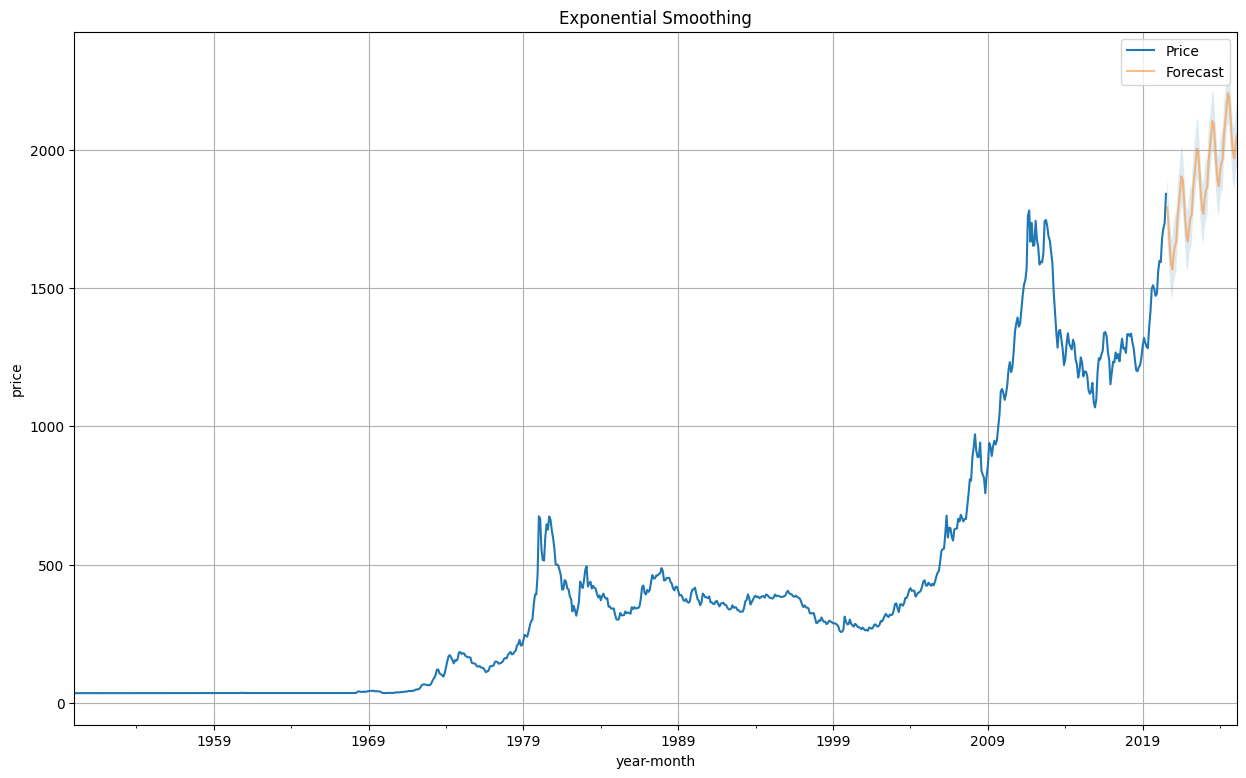

In [ ]:
axis=df.plot(label='Actual',figsize=(15,9))
pred_df['predictions'].plot(ax=axis,label='Forecast',alpha=0.5)
axis.fill_between(pred_df.index,pred_df['lower_CI'],pred_df['upper_CI'],alpha=0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc='best')
plt.title('Exponential Smoothing')

plt.grid()
plt.show()